# Phase profile in directed Human Brain Connectome

In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_surf
from src import operations
from src import graph_utils
from src import jordanzero_destroy

import h5py
import nibabel as nib
from scipy.io import loadmat

import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]

## Description

Phase profile in directed human brain connectome

GOAL: Analyse phase profile of of HCP task fMRI

## Table of Contents
- [Phase Profile in fMRI](#phase-profile)

In [2]:
resource_path = '../resources/'
data_path = '/Users/mikichan/Desktop/mywork/atlas_data/'

## Graph Phase profile - Test / Retest

#### Loading Graph and Transform

In [3]:
package = utils.load(utils.op.join(resource_path, 'brain_directed_graph/bin_directed_connectome_ftract+structural-d50+metadata.pkl'))
A, roi_atlas, region_labels = package['struct'], package['atlas'], package['regionnames']

nb_nodes = A.shape[0]

A = operations.normalize_adjacency(A)
L, U, V, Uinv, _, _, _ = graph_utils.prep_transform(A, gso="laplacian")

Method chosen is: eig


#### Preparing Motor fMRI

In [44]:
TR = 0.72
# list_subjects = ['100307', '100408', '101107', '101309', '101915']
list_subjects = ['101915']
taskparadigms1 = []
taskparadigms2 = []

for subject in list_subjects:
    taskparadigms1.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_LR.mat'))['Regressor'][0])
    taskparadigms2.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_RL.mat'))['Regressor'][0])
taskparadigms1 = np.concatenate(taskparadigms1)
taskparadigms2 = np.concatenate(taskparadigms2)
ntimepoints = taskparadigms1.shape[-1]

print(f"Number of timepoints = {ntimepoints}")

Number of timepoints = 284


In [45]:
# HCP task data - atlasing
motor_volume1 = []
motor_volume2 = []
for subject in tqdm(list_subjects):
    subpath2volumes = f'HCP_sample/HCP_motor/volume/{subject}/'
    file_list1 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_LR/fMRIvols_GLMyes'))
    reorder_list1 = np.argsort([int(file[-8:-4]) for file in file_list1 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list1 = np.array(file_list1)[reorder_list1]
    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_LR/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list1])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s
    motor_volume1.append(tmpvol)

    file_list2 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_RL/fMRIvols_GLMyes'))
    reorder_list2 = np.argsort([int(file[-8:-4]) for file in file_list2 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list2 = np.array(file_list2)[reorder_list2]

    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_RL/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list2])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s
    motor_volume2.append(tmpvol)
    
motor_volume1 = np.concatenate(motor_volume1)
motor_volume2 = np.concatenate(motor_volume2)


100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


In [46]:
root_path = "../"

atlas_data, affine = roi_atlas.get_fdata(), roi_atlas.affine

motor1_roi_timecourses = np.zeros((nb_nodes, motor_volume1.shape[0]))
for k in range(1, nb_nodes + 1):
    motor1_roi_timecourses[k-1] = motor_volume1[:, atlas_data == k].mean(axis=1)

motor2_roi_timecourses = np.zeros((nb_nodes, motor_volume2.shape[0]))
for k in range(1, nb_nodes + 1):
    motor2_roi_timecourses[k-1] = motor_volume2[:, atlas_data == k].mean(axis=1)

motor1_roi_timecourses = zscore(motor1_roi_timecourses, axis=1)
motor2_roi_timecourses = zscore(motor2_roi_timecourses, axis=1)

#### Results

In [47]:
graph_fourier_timecourse1 = np.array([operations.GFT(motor1_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])
graph_fourier_timecourse2 = np.array([operations.GFT(motor2_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])

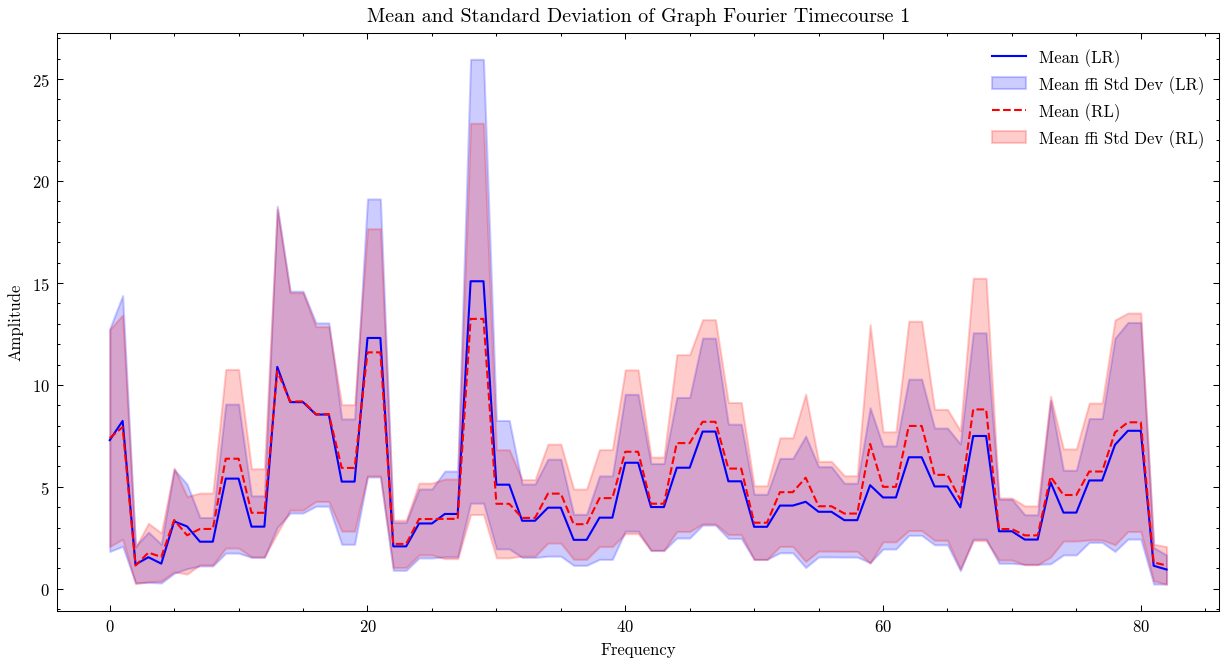

In [48]:
mean_gft1 = np.mean(np.abs(graph_fourier_timecourse1), axis=0)
std_gft1 = np.std(np.abs(graph_fourier_timecourse1), axis=0)

mean_gft2 = np.mean(np.abs(graph_fourier_timecourse2), axis=0)
std_gft2 = np.std(np.abs(graph_fourier_timecourse2), axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_gft1, label='Mean (LR)', color='b')
plt.fill_between(range(len(mean_gft1)), mean_gft1 - std_gft1, mean_gft1 + std_gft1, color='b', alpha=0.2, label='Mean ± Std Dev (LR)')

plt.plot(mean_gft2, label='Mean (RL)', color='r')
plt.fill_between(range(len(mean_gft2)), mean_gft2 - std_gft2, mean_gft2 + std_gft2, color='r', alpha=0.2, label='Mean ± Std Dev (RL)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Mean and Standard Deviation of Graph Fourier Timecourse 1')
plt.legend()
plt.show()

/Users/mikichan/miniconda3/envs/dGSP/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mikichan/miniconda3/envs/dGSP/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


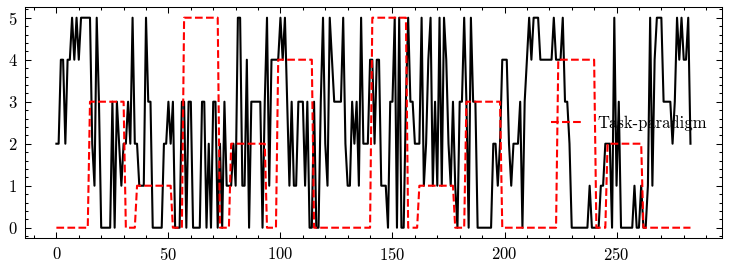

In [49]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 6

# Perform k-means clustering on graph_fourier_timecourse1
kmeans_gft = KMeans(n_clusters=n_clusters, random_state=0).fit(graph_fourier_timecourse1.real)
labels_gft = kmeans_gft.labels_

# Perform k-means clustering on motor1_roi_timecourses
kmeans_motor = KMeans(n_clusters=n_clusters, random_state=0).fit(motor1_roi_timecourses.T)
labels_motor = kmeans_motor.labels_

# Print the cluster centers for both
# print("Cluster centers for graph_fourier_timecourse1:\n", kmeans_gft.cluster_centers_)
# print("Labels for graph_fourier_timecourse1:\n", labels_gft)

# print("Cluster centers for motor1_roi_timecourses:\n", kmeans_motor.cluster_centers_)
# print("Labels for motor1_roi_timecourses:\n", labels_motor)
plt.figure(figsize=(6,2))
# plt.plot(labels_motor)
plt.plot(labels_gft)
plt.plot(taskparadigms1, label='Task-paradigm')
plt.legend()

Train Model accuracy: 95.07%
Test Model accuracy: 42.25%


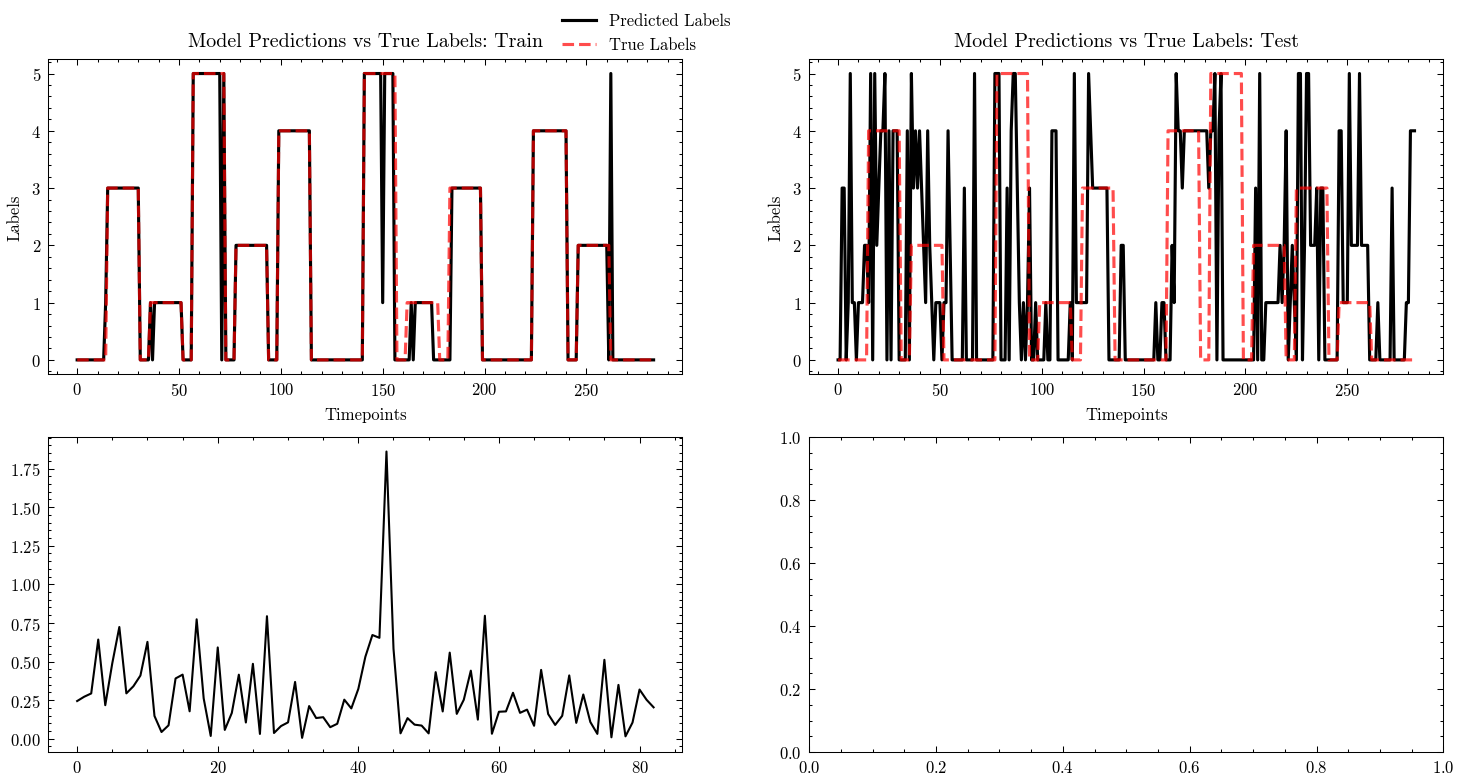

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from joblib import dump

binarized_task1 = (taskparadigms1 > 0).astype(int)
binarized_task2 = (taskparadigms2 > 0).astype(int)

# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_pipeline.fit(motor1_roi_timecourses.T, taskparadigms1)

# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
predicted_labels_logreg_train = logreg_pipeline.predict(motor1_roi_timecourses.T)
predicted_labels_logreg_test = logreg_pipeline.predict(motor2_roi_timecourses.T)

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0,0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0,0].plot(taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5)
ax[0,0].set_xlabel('Timepoints')
ax[0,0].set_ylabel('Labels')
ax[0,0].set_title('Model Predictions vs True Labels: Train')
ax[0,0].legend(loc=(0.8,1))
ax[0,1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[0,1].plot(taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[0,1].set_xlabel('Timepoints')
ax[0,1].set_ylabel('Labels')
ax[0,1].set_title('Model Predictions vs True Labels: Test')

ax[1,0].plot(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[0]))

Train Model accuracy: 89.08%
Test Model accuracy: 38.03%


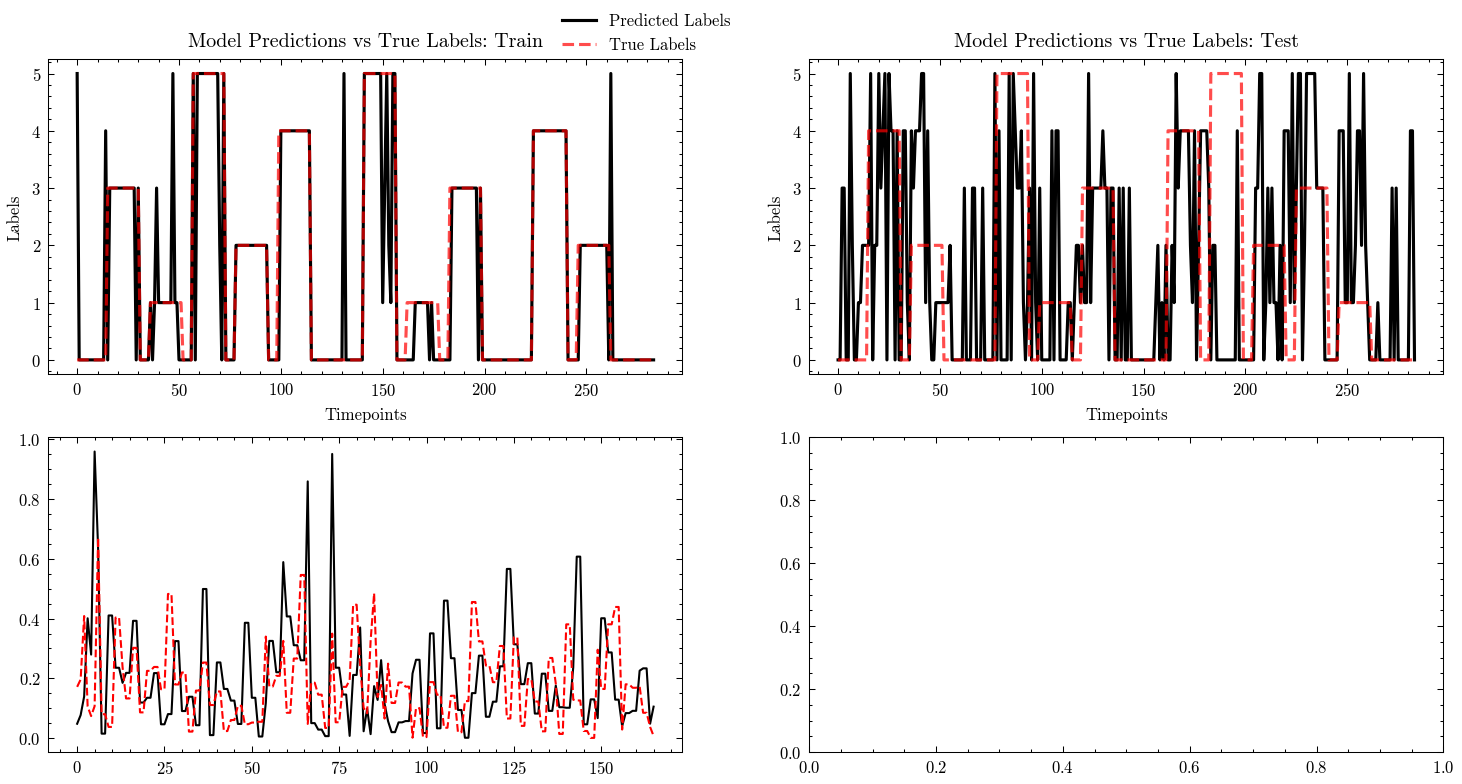

In [68]:
binarized_task1 = (taskparadigms1 > 0).astype(int)
binarized_task2 = (taskparadigms2 > 0).astype(int)

# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_pipeline.fit(np.concatenate((graph_fourier_timecourse1.real, graph_fourier_timecourse1.imag), axis=1), taskparadigms1)

# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
predicted_labels_logreg_train = logreg_pipeline.predict(np.concatenate((graph_fourier_timecourse1.real, graph_fourier_timecourse1.imag), axis=1))
predicted_labels_logreg_test = logreg_pipeline.predict(np.concatenate((graph_fourier_timecourse2.real, graph_fourier_timecourse2.imag), axis=1))

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0,0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0,0].plot(taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5)
ax[0,0].set_xlabel('Timepoints')
ax[0,0].set_ylabel('Labels')
ax[0,0].set_title('Model Predictions vs True Labels: Train')
ax[0,0].legend(loc=(0.8,1))
ax[0,1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[0,1].plot(taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[0,1].set_xlabel('Timepoints')
ax[0,1].set_ylabel('Labels')
ax[0,1].set_title('Model Predictions vs True Labels: Test')

ax[1,0].plot(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[0]))
ax[1,0].plot(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[1]))

#### Evolution of coefficient of a single frequency

In [63]:
operations.eigvalues_pairs(V)[-15:]

[array([59]),
 array([60, 61]),
 array([62, 63]),
 array([64, 65]),
 array([66]),
 array([67, 68]),
 array([69, 70]),
 array([71, 72]),
 array([73]),
 array([74, 75]),
 array([76, 77]),
 array([78]),
 array([79, 80]),
 array([81]),
 array([82])]

In [57]:
np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[0])[73]

0.9506331094176806

In [55]:
np.argsort(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[0]))

array([111, 112,  52,  53,  72,  71,  78,  38,  39,  84,   8,   7, 100,
        99,  91,  90,  82,  69,  70, 104, 103, 156,  34,  35, 146, 145,
        24,  25,  46,  47,   0, 164,  67,  68,  93,  92,  89,  95,  94,
       149, 117, 118,   1,  27,  26, 132, 131, 158, 157,  30,  31, 135,
       136, 160, 159, 110, 109,  83, 141, 140, 138, 139, 165,  88,  54,
        18,  19, 119, 120,  44,  45,  86, 155, 154, 147, 148,  21,  20,
        50,  51,  33,  32,   2,  77,  76, 114, 113,  43,  42,  85, 137,
       127, 128,  13,  80,  79, 133, 134,  96,  23,  22,  14,  15,  58,
        57, 161, 162, 163,  11,  12,  75,  74, 142, 121, 122, 130, 129,
        40,  41,  64,  65,  87,  97,  98, 108, 107, 115, 116,   4, 152,
       153,  63,  62, 125, 126,  29,  28,  56,  55, 102, 101,  81,  49,
        48,  17,  16,   3, 150, 151,  61,  60,   9,  10, 106, 105,  37,
        36, 123, 124,  59, 143, 144,   6,  66,  73,   5])

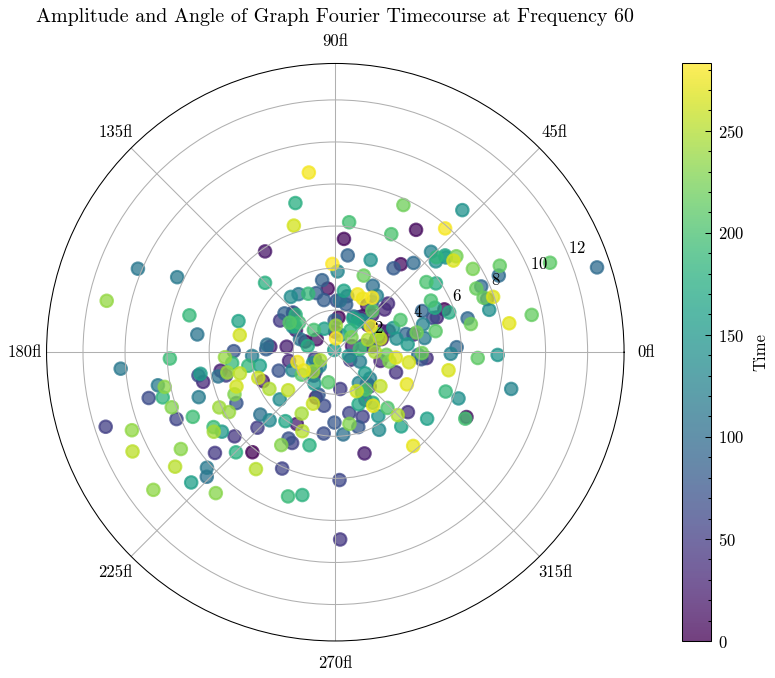

In [67]:
amp, angle = np.abs(graph_fourier_timecourse1[:, 60]), np.angle(graph_fourier_timecourse1[:, 60])
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 5))
c = ax.scatter(angle, amp, c=np.arange(len(amp)), cmap='viridis', alpha=0.75)
fig.colorbar(c, ax=ax, label='Time')
ax.set_title('Amplitude and Angle of Graph Fourier Timecourse at Frequency 60')
plt.show()

## Graph Phase profile - Rest vs Motor